In [158]:
import numpy as np
import pandas as pd
from copy import deepcopy as copy
from collections import Counter
import operator



In [231]:
def sudoku_to_dimacs(file_name = "data/1000_sudokus.txt"):
    f = open(file_name, "r")
    lines = f.readlines()
    total_dimacs = []
    for i, sudoku in enumerate(lines):
        dimacs_sudoku = []
        for j, cell in enumerate(sudoku):
            row, column = divmod(j, 9)
            if cell=="." or cell == '\n':
                continue
            else:
                
                dimacs_sudoku.append(str(row+1)+str(column+1)+str(cell))  
        total_dimacs.append(dimacs_sudoku)
    return total_dimacs
            
test_sudokus = sudoku_to_dimacs()


In [213]:
divmod(9, 9)

(1, 0)

There are few ways we can encode the CNF variables and literals. 
1. Any variable as x (which is already given in the DIMACS) and positive literals as 2x and negative literals as 2x+1. Benefits: bitwise operations. Downsides: I stole it. 
2. List of tuples, where 0th element is the variable and 1st element is a binary variable that signifies if it's a positive or a negative. 

In [314]:
#clause representation
clauses=[{1:0,2:1,3:0},[{4:1,2:0}]]
#variable representation
test_var = {1:[True, 0], 2: [False, 0,1,1], 3:[None, 0,1], 4:[None, 1,2,2] }

def transform_dict(l):
    new_dict = {}
    for element in l:
        if element[0]=="0": 
            break  
        elif element[0] == "-":
            key = int(element[1:])
        else:
            key = int(element)
        new_dict[key]=[]
    
    for element in l:
        if element[0]=="0": 
            break  
        elif element[0] == "-":
            new_dict[int(element[1:])].append(0)
        else:
            new_dict[int(element)].append(1)
    
    return new_dict



def read_dimac(file_name = "data/sudoku-rules.txt", is_txt = True):
    #read file
    if is_txt:
        f = open(file_name, "r")
        lines = f.readlines()
    else:
        lines = file_name
        
    #generate variables
    clauses={}
    variables = {}

    #for each clause
    for i, line in enumerate(lines):
        if is_txt:
            if i == 0:
                continue
        
        clause = transform_dict(line.split())
        clauses[int(i+3)] = clause
        for key in clause.keys():
            try:
                variables[key].append(i+3)
            except:
                variables[key] = [None]
                variables[key].append(i+3)

    return clauses, variables

clauses, variables =read_dimac()                       
clauses_example, variables_example =read_dimac(file_name = "data/sudoku-example.txt")  


def merge (variables_1, variables_2, clauses_1, clauses_2):
    len_1 = max(clauses_1)
    clauses_2_new = {}
    for idx, clause in clauses_2.items():
        idx_new = idx+len_1
        clauses_1[idx_new] = clause
        for variable in clause:
            variables_1[variable].append(idx_new)
        
    return variables_1, clauses_1
    print(clauses_2)
   # print(list(map(len,[variables_1, variables_2, clauses_1, clauses_2 ])))

clauses, variables =read_dimac()                       
clauses_example, variables_example =read_dimac(file_name = "data/sudoku-example.txt")  

variables, clauses = merge( variables,  variables_example, clauses, clauses_example)



In [163]:
def remove_tautology(clauses, variables):
    # for each variable
    for var_name, var_idx in variables.items():
        # check if variable has double occurance in any clause
        duplicates = set([x for x in var_idx[1:] if var_idx[1:].count(x) > 1])
        #if not, continue
        if len(duplicates) == 0:
            continue
        #for each clause where variable occurs twice
        for idx in duplicates:
            is_break = False
            #for each literal of that variable in the clause
            for literal_i in  clauses[idx][var_name]:
                #double_break
                if is_break:
                    break
                #for every other literal
                for literal_j in clauses[idx][var_name]:
                    #if there is a tautology
                    if literal_i != literal_j:
                        #remove this clause
                        del clauses[idx]
                        #removing index of this clause from variables
                        for var_name_2, var_idx_2 in variables.items():
                            new_var = [var_idx_2[0]] + [x for x in var_idx_2[1:] if x != idx]
                            variables[var_name_2] = new_var
                        
                        #double break
                        is_break = True
                        break
    return clauses, variables
            #print(idx,var_name)
            #print(clauses[idx][var_name])

test_var = {1:[None, 0], 2: [None, 0,1,1], 3:[None, 0,1], 4:[None, 1,2,2] }
test_clauses = {0:{1:[0],2:[1],3:[0]},1:{4:[1],2:[0,1], 3:[1]},2:{4:[0,1]}}
remove_tautology(test_clauses, test_var)


({0: {1: [0], 2: [1], 3: [0]}},
 {1: [None, 0], 2: [None, 0], 3: [None, 0], 4: [None]})

In [315]:
def delete_clause(idx, clauses, variables):
    
    #remove the clause from mentions in all variables
    for variable in clauses[idx]:

        new_var = [variables[variable][0]] + [x for x in variables[variable][1:] if x!=idx]
        variables[variable] = new_var
        
    #delete the clause
    del clauses[idx]
   
    return clauses, variables


def belief_propogation(variable, clauses, variables):
    truth_value = variables[variable][0]

    for clause in variables[variable][1:]:
        if truth_value == clauses[clause][variable][0]:
            clauses, variables = delete_clause(clause, clauses, variables)
        else:
        
            new_var = [variables[variable][0]] + [x for x in variables[variable][1:] if x!=clause]
            variables[variable] = new_var
            del clauses[clause][variable]
    return clauses, variables
    

def unit_check(clauses, variables):
    
    generator = ( (idx, clause) for (idx, clause) in clauses.items() )
    empty = True
    for idx, clause in  generator:
        
        if len(clause) == 1:
            variable = list(clause.keys())[0]
            literal = list(clause.values())[0][0]
            
            if literal:
                variables[variable][0] = True  
                clauses, variables = delete_clause(idx, clauses, variables)
                clauses, variables = belief_propogation(variable, clauses, variables)
                empty = False
                break
            else:
                variables[variable][0] = False  
                clauses, variables = delete_clause(idx, clauses, variables)
                clauses, variables = belief_propogation(variable, clauses, variables)
                empty = False
                break
          
                
                
            
    return clauses, variables, empty
                
            
test_var = {1:[None, 0, 3], 2: [None, 0,1,1], 3:[None, 0,1], 4:[None, 1,2,2] }
test_clauses = {0:{1:[0],2:[1],3:[0]},1:{4:[1],2:[0,1], 3:[1]},2:{4:[1]}, 3:{1:[0]}}
unit_check(test_clauses, test_var)


({0: {1: [0], 2: [1], 3: [0]}, 3: {1: [0]}},
 {1: [None, 0, 3], 2: [None, 0], 3: [None, 0], 4: [True]},
 False)

In [165]:
def check_for_empty_clause(clauses):
    for clause in clauses.values():
        if len(clause) == 0:
            return True
    return False
def check_emptiness(clauses):
    if len(clauses) == 0:
        return True
    return False

In [166]:
# VIDS heuristic

# TODO Initialize counter beforehand:
# var_counter = Counter()

def heu1(clauses, variables, var_counter):
    alpha = 0.5
    for key, value in variables.items():
        if len(value[1:]) > 0:
            var_counter[key] += len(value[1:]) *alpha
    next_var = var_counter.most_common(1)[0][0] if var_counter else None
    return next_var, var_counter
            
def jeroslow(clauses, variables):
   
    J = {key:0 for key in variables.keys()}
    for variable_key, variable_clauses in variables.items():
        for clause_idx in variable_clauses[1:]:
            if clauses[clause_idx][variable_key][0] == 1:
                
                J[variable_key]+=len(clauses[clause_idx])
   
    #print( max(J.items(), key=operator.itemgetter(1))[0], J[ max(J.items(), key=operator.itemgetter(1))[0]])
    return max(J.items(), key=operator.itemgetter(1))[0]
        
            

In [233]:

def dpll(clauses, variables, heuristic, metrics):
    var_counter = Counter()
    while True:
        #simplification round
        
        while True:
            #simplify
            
            clauses, variables, empty = unit_check(clauses, variables)
            
            if empty:
                break
        #print(0)    
        if check_for_empty_clause(clauses):
            #print("Empty clause")
            return False, variables, clauses, metrics
            
        if check_emptiness(clauses):
            #print("Empty conjunction of  clauses")
            return True, variables, clauses, metrics
            
            
        #split randomly for now
        if heuristic == 0:
            variable = np.random.choice([key for (key, value) in variables.items() if value[0]==None])
        elif heuristic == 1:
            variable, var_counter = heu1(clauses, variables, var_counter)
        elif heuristic == 2:
            
            variable = jeroslow(clauses, variables)
        
        #copy variables and clauses
        variables_new, clauses_new = copy(variables), copy(clauses)
        unsat_clauses = len(clauses)
        #metrics
        if len(metrics) == 0: 
            metrics.append([len(clauses), 0])
        else:
            backtracks = metrics[-1][1]
            metrics.append([len(clauses), backtracks])
        #set variable to True
        variables_new[variable][0] = True
        clauses_new, variables_new  = belief_propogation(variable, clauses_new, variables_new)
        is_true, variables_new, clauses_new, metrics = dpll(clauses_new, variables_new, heuristic, metrics)
        if is_true:
            #print("TRUE")
            return True, variables_new, clauses_new, metrics
        else:
            #metrics
            backtracks = metrics[-1][1]
            metrics.append([len(clauses), backtracks+1])
            #print(1)
            variables[variable][0] = False
            clauses, variables = belief_propogation(variable, clauses, variables)
            is_true, variables, clauses, metrics = dpll(clauses, variables, heuristic, metrics)
            #print("SAT")
            return is_true, variables, clauses, metrics
            
       
    print("NOT SAT")
    return False

test_var = {1:[None, 0, 3], 2: [None, 0,1], 3:[None, 0,1], 4:[None, 1,2,2] }
test_clauses = {0:{1:[0],2:[1],3:[0]},1:{4:[0],2:[0],3:[1]},2:{4:[1]}, 3:{1:[0]}}
#test_clauses, test_var = remove_tautology(test_clauses, test_var)
test_clauses, test_var = remove_tautology(test_clauses, test_var)
dpll(test_clauses, test_var, heuristic = 1 , metrics = [])


(True, {1: [False], 2: [True], 3: [True], 4: [True]}, {}, [[1, 0]])

In [234]:
np.random.seed(10312343)
var_counter = Counter()
clauses, variables =read_dimac()                       
clauses_example, variables_example =read_dimac(file_name = "data/sudoku-example.txt")  
variables, clauses = merge( variables,  variables_example, clauses, clauses_example)
clauses, variables = remove_tautology(clauses, variables)
t, variables, clauses, metrics = dpll(clauses, variables, 0 , metrics = [])
# metrics are a list of tuples, where len of the list is number of splits, 0th element of the tuple is # of unsat and the 1st element is # of backtracks

In [171]:
#variables with empty clauses
keys=[]
#for each clause
for key, value in clauses.items():
    #if clause is empty
    if len(value) == 0:
        #append this clause
        keys.append(key)
#for each variable
for variable, clauses_idx in variables.items():
    for clause in clauses_idx:
        if clause in keys:
            print(variables[variable])


In [172]:
len(clauses)


0

In [236]:
def check_sudoku(variables):
    summ=0
    for key, var in variables.items():
        if var[0]==True:
            summ+=1
    if summ == 81:
        return True
    return False

#check for number of trues
result_list = []

summ=0
for key, var in variables.items():
    if var[0]==True:
        result_list.append(key)
        summ+=1
print(summ)
check_sudoku(variables)

81


True

In [193]:
metrics

[[2509, 0],
 [2148, 0],
 [1916, 0],
 [1719, 0],
 [1511, 0],
 [1511, 1],
 [1496, 1],
 [955, 1],
 [955, 2],
 [945, 2],
 [773, 2],
 [484, 2],
 [160, 2],
 [120, 2],
 [32, 2]]

In [181]:
import matplotlib.pyplot as plt
import pylab as pl

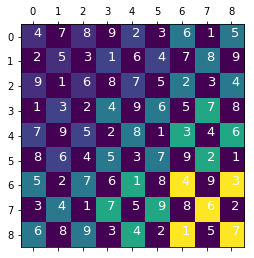

In [216]:
# visualize the sudoku

# Make a 9x9 grid...
nrows, ncols = 9,9
sudoku_grid = np.zeros(nrows*ncols)

im2 = [2,2,3,6,6,2,3,3,6,2,2,3,6,6,3,6,6,9,3,3,6,9,9,3,6,6,9,6,6,9,15,15,6,9,9,15,6,6,9,15,15]

#sudoku_grid[::2] = np.random.random(41)
sudoku_grid[::2] = im2

sudoku_grid = sudoku_grid.reshape((nrows, ncols))
plt.matshow(sudoku_grid)

for result in result_list:
    xyn = [int(d) for d in str(result)]
    pl.text(xyn[0]-1, xyn[1]-1, str(xyn[2]), color="white", fontsize=13)
pl.show()

In [317]:
#experimenting
np.random.seed(103493)
test_sudokus_list = sudoku_to_dimacs()
var_counter = Counter()
t_list = []
list81 = []
var_list = []
metrics_list = []
for sudoku in test_sudokus_list:
    clauses_rules, variables_rules = read_dimac() 
    clauses_example, variables_example = read_dimac(file_name = sudoku, is_txt = False)  
    variables, clauses = merge(variables_rules,  variables_example, clauses_rules, clauses_example)
    clauses, variables = remove_tautology(clauses, variables)
    t, variables, clauses, metrics = dpll(clauses, variables, 0 , metrics = [])
    t_list.append(t)
    list81.append(check_sudoku(variables))
    var_list.append(variables)
    metrics_list.append(metrics)

# metrics are a list of tuples, where len of the list is number of splits, 0th element of the tuple is # of unsat and the 1st element is # of backtracks

In [321]:
summ = 0
for statement in list81:
    if statement == True:
        summ+=1

summ

1011

In [333]:
avg_num_backtracks = 0
avg_num_of_splits = 0
empty=0
for metrics in metrics_list:
    if len(metrics)==0:
        empty+=1
        continue
    avg_num_backtracks+=metrics[-1][1]
    avg_num_of_splits+=len(metrics)
print(avg_num_of_splits/(len(metrics_list)-empty), avg_num_backtracks/(len(metrics_list)-empty))

14.305449936628644 6.475285171102661
